In [50]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']


def get_embedding(text):
    '''Compute GPT3-embedding for a given text string'''
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

In [117]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

In [121]:
for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)

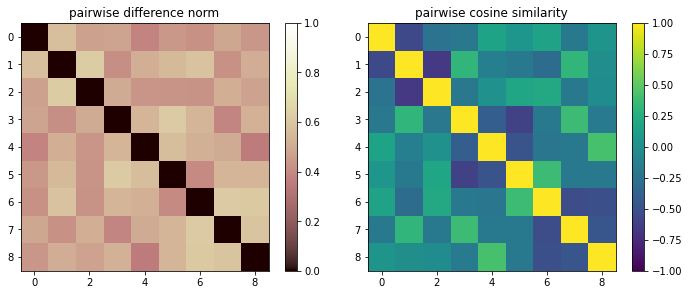

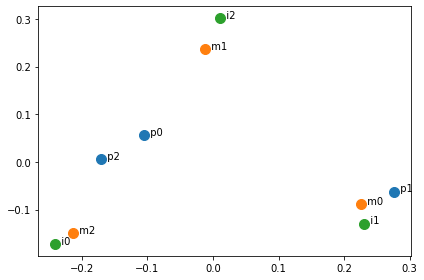

In [123]:
embs = people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist()
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

# plot embedding pca
emb_pca = PCA(n_components=2).fit_transform(embs)
people_pca, messages_pca, images_pca = np.split(emb_pca, [len(people),-len(images)])
fig, ax = plt.subplots(figsize=(6,4))
# plot people pca
ax.scatter(people_pca[:,0], people_pca[:,1], s=100)
for ind, pnt in enumerate(people_pca):
    ax.annotate(f'  p{ind}', pnt)
# plot messages pca
ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
for ind, pnt in enumerate(messages_pca):
    ax.annotate(f'  m{ind}', pnt)
# plot images pca
ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
for ind, pnt in enumerate(images_pca):
    ax.annotate(f'  i{ind}', pnt)
plt.tight_layout()
plt.show()